# PySpark example - NSL-KDD

This notebooks uses PySpark to work the KDD99 challenge using the NSL-KDD optimized dataset from [this github](https://github.com/jmnwong/NSL-KDD-Dataset).

It is to be noticed that the test dataset contains more attack types than the ones present in the training dataset.

The code is widely inspired from [this example](https://github.com/thinline72/nsl-kdd/blob/master/NSL-KDD.ipynb).

The notebook is organized as follow:

0. Prepare the context    
1. Load the training data (sampled or full)
2. Explore the dataset (and do some cleaning)
3. Prepare the data (re-organise and index, vizualise dimensions)
4. Train a random-forest and a logistic-regression models, and evaluate them

## 0. Prepare the context
* import the needed packages
* Set the parallelization level
* Set a seed that allows reproducability of pseudo-random operations
* Create the SparkSession to be used as `spark`

In [1]:
# Spark and SparkSQL related imports
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col, lit
import pyspark.sql.functions as sql

# Spark ML related imports
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, IndexToString, OneHotEncoder, \
                               StandardScaler, VectorAssembler, VectorIndexer, PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Other imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

In [2]:
parallelizationLevel = 4

In [3]:
# Setting seed for reproducibility
seed = 1928374650123456789

In [4]:
spark_conf = SparkConf().setAll([
    ('spark.executor.memory', '1g'),
    ('spark.driver.memory', '1g')
])

spark = SparkSession \
    .builder \
    .master('local[{0}]'.format(parallelizationLevel)) \
    .getOrCreate()
print('Spark version {0} started'.format(spark.version))

Spark version 2.3.0 started


## 1. Load the data

* Initialize files paths
* Initialize data format (columns names and types)
* Define a loading a function that adds 2 columns for simplified labels (labels2: attack / normal, labels5: normal, DoS, Probe, R2L, U2R) and 1 column facilitating identifying the source dataset when unioned (ds: train / train20 / test)
* Use the loading function over the file paths to load the dataframes

In [5]:
train_nsl_kdd_dataset_path = "NSL-KDD-Dataset/KDDTrain+.txt"
train20_nsl_kdd_dataset_path = "NSL-KDD-Dataset/KDDTrain+_20Percent.txt"
test_nsl_kdd_dataset_path = "NSL-KDD-Dataset/KDDTest+.txt"

In [6]:
col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels", "difficulty_group"])

nominal_inx = [1, 2, 3]
binary_inx = [6, 11, 13, 14, 20, 21]
numeric_inx = list(set(range(41)).difference(nominal_inx).difference(binary_inx))

nominal_cols = col_names[nominal_inx].tolist()
binary_cols = col_names[binary_inx].tolist()
numeric_cols = col_names[numeric_inx].tolist()

In [7]:
# This attack dictionnary contains labels existing only in test data - see below.
attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
     'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

attack_mapping_udf = udf(lambda v: attack_dict[v])

def load_dataset(path, dsType):
    dataset_rdd = spark.sparkContext.textFile(path, parallelizationLevel).map(lambda line: line.split(','))
    dataset_df = (dataset_rdd.toDF(col_names.tolist()).select(
                    col('duration').cast(DoubleType()),
                    col('protocol_type').cast(StringType()),
                    col('service').cast(StringType()),
                    col('flag').cast(StringType()),
                    col('src_bytes').cast(DoubleType()),
                    col('dst_bytes').cast(DoubleType()),
                    col('land').cast(DoubleType()),
                    col('wrong_fragment').cast(DoubleType()),
                    col('urgent').cast(DoubleType()),
                    col('hot').cast(DoubleType()),
                    col('num_failed_logins').cast(DoubleType()),
                    col('logged_in').cast(DoubleType()),
                    col('num_compromised').cast(DoubleType()),
                    col('root_shell').cast(DoubleType()),
                    col('su_attempted').cast(DoubleType()),
                    col('num_root').cast(DoubleType()),
                    col('num_file_creations').cast(DoubleType()),
                    col('num_shells').cast(DoubleType()),
                    col('num_access_files').cast(DoubleType()),
                    col('num_outbound_cmds').cast(DoubleType()),
                    col('is_host_login').cast(DoubleType()),
                    col('is_guest_login').cast(DoubleType()),
                    col('count').cast(DoubleType()),
                    col('srv_count').cast(DoubleType()),
                    col('serror_rate').cast(DoubleType()),
                    col('srv_serror_rate').cast(DoubleType()),
                    col('rerror_rate').cast(DoubleType()),
                    col('srv_rerror_rate').cast(DoubleType()),
                    col('same_srv_rate').cast(DoubleType()),
                    col('diff_srv_rate').cast(DoubleType()),
                    col('srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_count').cast(DoubleType()),
                    col('dst_host_srv_count').cast(DoubleType()),
                    col('dst_host_same_srv_rate').cast(DoubleType()),
                    col('dst_host_diff_srv_rate').cast(DoubleType()),
                    col('dst_host_same_src_port_rate').cast(DoubleType()),
                    col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_serror_rate').cast(DoubleType()),
                    col('dst_host_srv_serror_rate').cast(DoubleType()),
                    col('dst_host_rerror_rate').cast(DoubleType()),
                    col('dst_host_srv_rerror_rate').cast(DoubleType()),
                    col('labels').cast(StringType()),
                    col('difficulty_group').cast(StringType())))

    return dataset_df \
        .withColumn('ds', lit(dsType)) \
        .withColumn('labels2', sql.regexp_replace(col('labels'), '^(?!normal).*$', 'attack')) \
        .withColumn('labels5', attack_mapping_udf(col('labels'))) \
        .cache()

In [8]:
train_df = load_dataset(train_nsl_kdd_dataset_path, 'train')
train20_df = load_dataset(train20_nsl_kdd_dataset_path, 'train10')
test_df = load_dataset(test_nsl_kdd_dataset_path, 'test')

## 2. Explore the data

The DataFrame API of Spark is SQL-oriented. It allows for easily exploring datasets. The approach we take is to union the 3 datasets, using the `ds` column to differentiate their rows in the union.

We are also making extensive use of the Spark-to-Pandas easy conversion, to easily plot small data.

In [9]:
# Union the three dataframe to easily get stats for all through groupDy('ds')
all_df = train_df.union(train20_df).union(test_df).repartition(parallelizationLevel).cache()

### Dataset size and number of labels

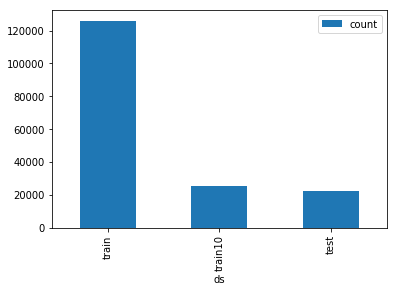

In [10]:
#
all_df.groupBy('ds').count().toPandas().plot(x='ds', kind='bar')

AxesSubplot(0.125,0.125;0.775x0.755)


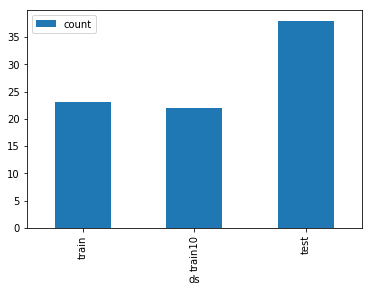

In [11]:
print(all_df.select('ds', 'labels').distinct().groupBy('ds').count().toPandas().plot(x='ds', kind='bar'))

As expected, the test dataset has a lot more labels than the training one.

### Labels2 count (normal / attack)

In [12]:
# Extract labels2 counts into a pandas dataframe and pivot it
labels2_pdf = all_df.groupBy('ds', 'labels2').count().toPandas() \
    .pivot(index='ds', columns='labels2', values='count')

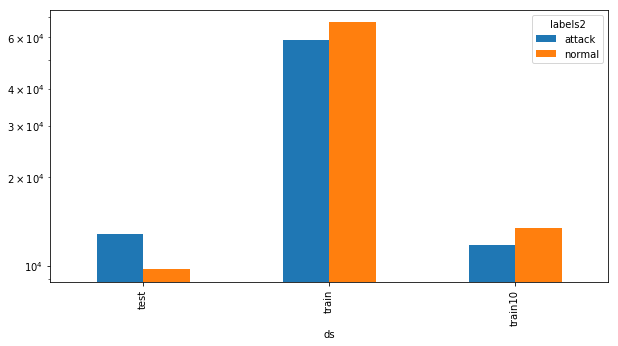

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
labels2_pdf.plot(kind='bar', logy=True, ax=ax)

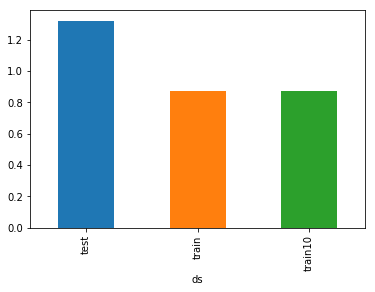

In [14]:
labels2_pdf['attack_normal_ratio'] = labels2_pdf['attack'] / labels2_pdf['normal']
labels2_pdf['attack_normal_ratio'].plot(x='ds', kind='bar')

Ratio of attacks vs. normal is significatively higher in test dataset than in train one.

### Labels5 count (normal / DoS / Probe / R2L / U2R)

In [15]:
labels5_pdf = all_df.groupBy('ds', 'labels5').count().toPandas() \
    .pivot(index='ds', columns='labels5', values='count')

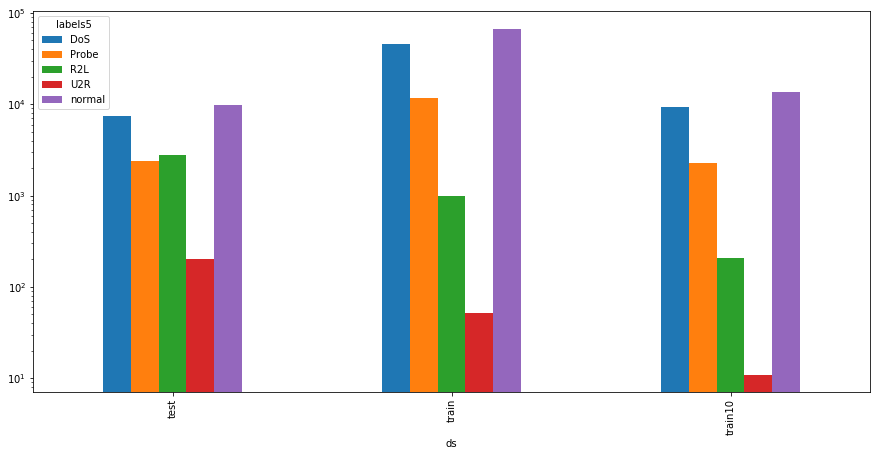

In [16]:
fig, ax = plt.subplots(figsize=(15, 7))
labels5_pdf.plot(kind='bar', logy=True, ax=ax)

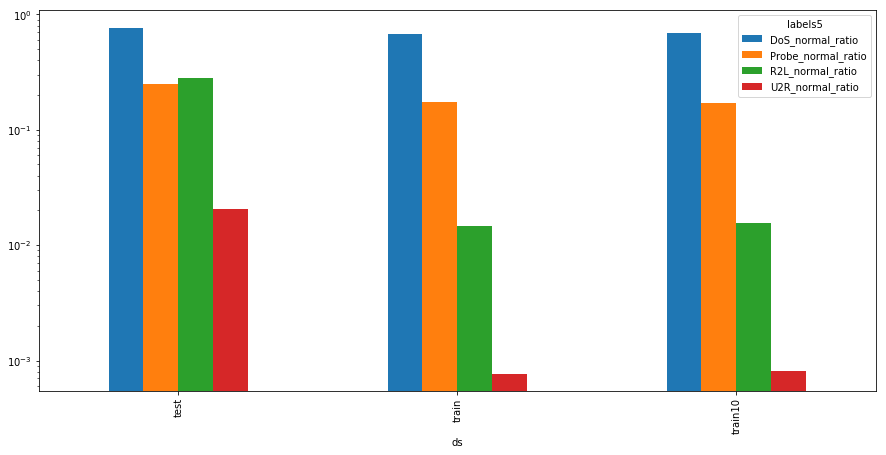

In [17]:
attack_types = ['DoS', 'Probe', 'R2L', 'U2R']
for attack in attack_types:
    labels5_pdf['{0}_normal_ratio'.format(attack)] = labels5_pdf[attack] / labels5_pdf['normal']
fig, ax = plt.subplots(figsize=(15, 7))
labels5_pdf[['{0}_normal_ratio'.format(a) for a in attack_types]].plot(logy=True, kind='bar', ax=ax)

Reason of difference of attack / normal ratio is due to `R2L` and `U2R` attack types

### Labels count (all labels)

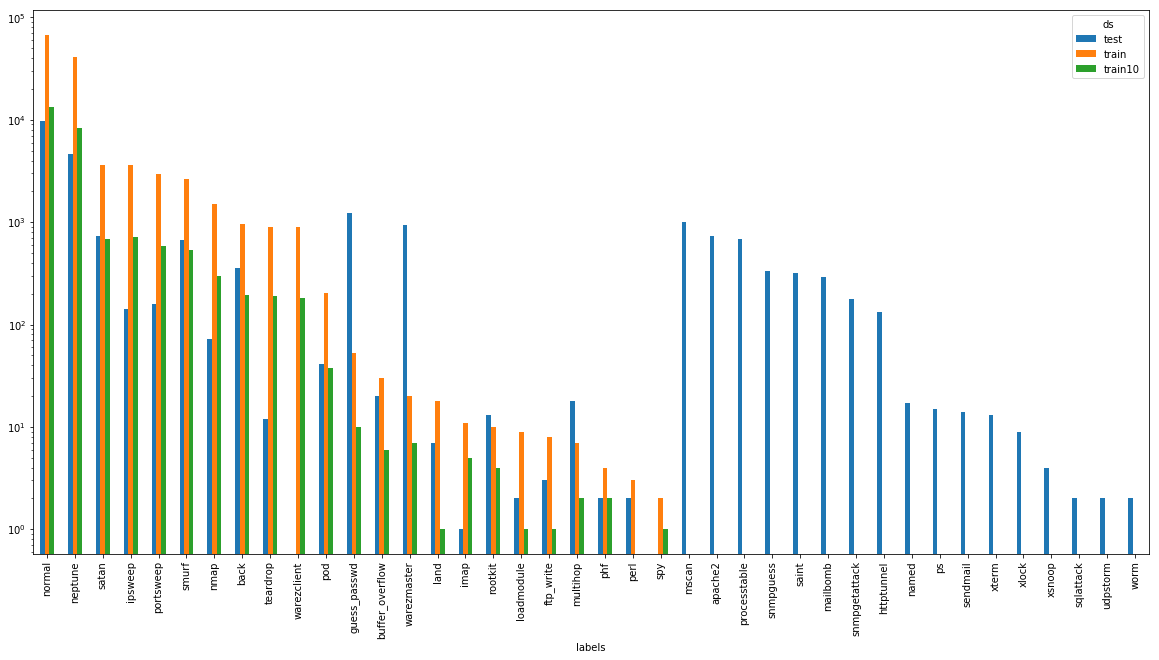

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
all_df.groupBy('ds', 'labels').count().toPandas() \
    .pivot(index='labels', columns='ds', values='count') \
    .sort_values(by=['train', 'test'], ascending=False) \
    .plot(kind='bar', logy=True, ax=ax)

The difference in atack / normal ratio is not only related to new attack types (see guess_passwd and warezmaster for instance)

### Dimensions Analysis - Nominal columns

In [19]:
# 'protocol_type' column
(train_df.crosstab(nominal_cols[0], 'labels2').sort(sql.asc(nominal_cols[0] + '_labels2')).show())
(train_df.crosstab(nominal_cols[0], 'labels5').sort(sql.asc(nominal_cols[0] + '_labels5')).show())

+---------------------+------+------+
|protocol_type_labels2|attack|normal|
+---------------------+------+------+
|                 icmp|  6982|  1309|
|                  tcp| 49089| 53600|
|                  udp|  2559| 12434|
+---------------------+------+------+

+---------------------+-----+-----+---+---+------+
|protocol_type_labels5|  DoS|Probe|R2L|U2R|normal|
+---------------------+-----+-----+---+---+------+
|                 icmp| 2847| 4135|  0|  0|  1309|
|                  tcp|42188| 5857|995| 49| 53600|
|                  udp|  892| 1664|  0|  3| 12434|
+---------------------+-----+-----+---+---+------+



In [20]:
# 'service' column
(train_df.crosstab(nominal_cols[1], 'labels2').sort(sql.asc(nominal_cols[1] + '_labels2')).show(n=70))
(train_df.crosstab(nominal_cols[1], 'labels5').sort(sql.asc(nominal_cols[1] + '_labels5')).show(n=70))

+---------------+------+------+
|service_labels2|attack|normal|
+---------------+------+------+
|            IRC|     1|   186|
|            X11|     6|    67|
|         Z39_50|   862|     0|
|            aol|     2|     0|
|           auth|   719|   236|
|            bgp|   710|     0|
|        courier|   734|     0|
|       csnet_ns|   545|     0|
|            ctf|   563|     0|
|        daytime|   521|     0|
|        discard|   538|     0|
|         domain|   531|    38|
|       domain_u|     9|  9034|
|           echo|   434|     0|
|          eco_i|  4089|   497|
|          ecr_i|  2887|   190|
|            efs|   485|     0|
|           exec|   474|     0|
|         finger|  1222|   545|
|            ftp|   836|   918|
|       ftp_data|  1876|  4984|
|         gopher|   518|     0|
|        harvest|     2|     0|
|      hostnames|   460|     0|
|           http|  2289| 38049|
|      http_2784|     1|     0|
|       http_443|   530|     0|
|      http_8001|     2|     0|
|       

In [21]:
# 'flag' column
(train_df.crosstab(nominal_cols[2], 'labels2').sort(sql.asc(nominal_cols[2] + '_labels2')).show())
(train_df.crosstab(nominal_cols[2], 'labels5').sort(sql.asc(nominal_cols[2] + '_labels5')).show())

+------------+------+------+
|flag_labels2|attack|normal|
+------------+------+------+
|         OTH|    35|    11|
|         REJ|  8540|  2693|
|        RSTO|  1343|   219|
|      RSTOS0|   103|     0|
|        RSTR|  2275|   146|
|          S0| 34497|   354|
|          S1|     4|   361|
|          S2|     8|   119|
|          S3|     4|    45|
|          SF| 11552| 63393|
|          SH|   269|     2|
+------------+------+------+

+------------+-----+-----+---+---+------+
|flag_labels5|  DoS|Probe|R2L|U2R|normal|
+------------+-----+-----+---+---+------+
|         OTH|    0|   35|  0|  0|    11|
|         REJ| 5671| 2869|  0|  0|  2693|
|        RSTO| 1216|   80| 46|  1|   219|
|      RSTOS0|    0|  103|  0|  0|     0|
|        RSTR|   90| 2180|  5|  0|   146|
|          S0|34344|  153|  0|  0|   354|
|          S1|    2|    1|  1|  0|   361|
|          S2|    5|    2|  1|  0|   119|
|          S3|    0|    1|  3|  0|    45|
|          SF| 4599| 5967|935| 51| 63393|
|          SH|    

### Dimensions analysis - Binary columns

In [22]:
train_df.select(binary_cols).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
land,125973,1.9845522453224102E-4,0.014086071671513094,0.0,1.0
logged_in,125973,0.3957355941352512,0.48901005300524064,0.0,1.0
root_shell,125973,0.0013415573178379495,0.036602843839798706,0.0,1.0
su_attempted,125973,0.0011034110483992602,0.04515438381386553,0.0,2.0
is_host_login,125973,7.938208981289641E-6,0.0028174827384191085,0.0,1.0
is_guest_login,125973,0.009422654060790804,0.0966123270914311,0.0,1.0


`su_attempted` should be a binary column, but seems to have 3 values

In [23]:
train_df.crosstab('su_attempted', 'labels2').show()

+--------------------+------+------+
|su_attempted_labels2|attack|normal|
+--------------------+------+------+
|                 2.0|     0|    59|
|                 1.0|     1|    20|
|                 0.0| 58629| 67264|
+--------------------+------+------+



In [24]:
# We replace `2.0` value by `0.0` for both train and test datasets
train_df = train_df.replace(2.0, 0.0, 'su_attempted')
test_df = test_df.replace(2.0, 0.0, 'su_attempted')

### Dimension analysis - Numeric columns

In [25]:
train_df.select(numeric_cols).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
duration,125973,287.1446500440571,2604.515309867591,0.0,42908.0
src_bytes,125973,45566.74300048423,5870331.181893554,0.0,1.379963888E9
dst_bytes,125973,19779.114421344257,4021269.1514414474,0.0,1.309937401E9
wrong_fragment,125973,0.022687401268525795,0.25352998595201304,0.0,3.0
urgent,125973,1.1113492573805498E-4,0.01436602662015425,0.0,3.0
hot,125973,0.20440888126820828,2.1499684337047613,0.0,77.0
num_failed_logins,125973,0.0012224841831186047,0.045239138981329884,0.0,5.0
num_compromised,125973,0.279250315543807,23.942042242795132,0.0,7479.0
num_root,125973,0.30219173949973405,24.399618088837432,0.0,7468.0


`num_outbound_cmds` seems to always be 0.0

In [26]:
train_df.crosstab('num_outbound_cmds', 'labels2').show()

+-------------------------+------+------+
|num_outbound_cmds_labels2|attack|normal|
+-------------------------+------+------+
|                      0.0| 58630| 67343|
+-------------------------+------+------+



We drop the column as it doesn't provide any information

In [27]:
train_df = train_df.drop('num_outbound_cmds')
test_df = test_df.drop('num_outbound_cmds')
numeric_cols.remove('num_outbound_cmds')

## 3. Prepare the data

Things to be done:
* Index labels into numbers (ML algorithms  expect so)
* Encode categorical columns using one-hot-encoding (actually index to number first, then one-hot-encode)
* Standardize numerical columns (use std_dev unity, do not center on mean since data is sparsed) - Better for distance-based algorithm
* Assemble all binary columns and the already assemble numrical vector into a feature vector, and index it (better perf)

Using ML Pipeline (see [the spark documentation](https://spark.apache.org/docs/2.2.0/ml-pipeline.html))

It is to be noticed that a feature selection step using attribute ratio could have been added (see original notebook for more)

Finally we also split the train dataset into a raining / cross-validation dataset (80% / 20%)

In [28]:
# String indexers and reverse operators for labels2 and labels5
labels2_indexer = StringIndexer(inputCol="labels2", outputCol="labels2_idx").fit(train_df)
labels2_converter = IndexToString(inputCol="labels2_pred_idx", outputCol="predicted_labels2",
                               labels=labels2_indexer.labels)
labels5_indexer = StringIndexer(inputCol="labels5", outputCol="labels5_idx").fit(train_df)
labels5_converter = IndexToString(inputCol="labels5_pred_idx", outputCol="predicted_labels5",
                               labels=labels5_indexer.labels)

In [29]:
# StringIndexers and OneHotEncoders for nominal columns
string_indexers = [labels2_indexer, labels5_indexer]
one_hot_encoders = []
for col in nominal_cols:
    col_idx = "{0}_idx".format(col)
    col_vec = "{0}_vec".format(col)
    string_indexers.append(StringIndexer(inputCol=col, outputCol=col_idx))
    one_hot_encoders.append(OneHotEncoder(inputCol=col_idx, outputCol=col_vec))
    # Add col_vec to the list of binary columns (if not yet there)
    if col_vec not in binary_cols:
        binary_cols.append(col_vec)

In [30]:
# Scaler for numeric columns - Works on a Vector, therefore assemble numeric columns in a vector first
numeric_assembler = VectorAssembler(inputCols=numeric_cols, outputCol='num_feats')
numeric_scaler = StandardScaler(inputCol="num_feats", outputCol="scaled_num_feats", withStd=True, withMean=False)

In [31]:
global_assembler = VectorAssembler(inputCols=binary_cols + ["scaled_num_feats"], outputCol='raw_feats')
global_indexer = VectorIndexer(inputCol='raw_feats', outputCol='idx_feats', maxCategories=2)

In [32]:
# Pipeline (without learning stage, only transformations)                           
preparation_pipeline = Pipeline(stages=string_indexers + one_hot_encoders +
    [numeric_assembler, numeric_scaler, global_assembler, global_indexer])
prep_model = preparation_pipeline.fit(train_df)                                         

In [33]:
# Applying to training and test dataset
prep_train_df = prep_model.transform(train_df) \
                    .select('idx_feats', 'labels2_idx', 'labels2', 'labels5_idx', 'labels5') \
                    .cache()
prep_test_df = prep_model.transform(test_df) \
                    .select('idx_feats', 'labels2_idx', 'labels2', 'labels5_idx', 'labels5') \
                    .cache()

In [34]:
# Splitting the train dataset into train and cross-validation
split = (prep_train_df.randomSplit([0.8, 0.2], seed=seed))

final_train_df = split[0].cache()
final_cv_df = split[1].cache()
final_test_df = prep_test_df

In [35]:
print(final_train_df.count())
print(final_cv_df.count())
print(final_test_df.count())

100724
25249
22544


In [36]:
# Prepare a PCA vizualization pipeline (2 dimensions)
pca = PCA(k=2, inputCol="idx_feats", outputCol="pca_feats")
pca_pipeline = Pipeline(stages=[pca])
pca_train_df = pca_pipeline.fit(final_train_df).transform(final_train_df)

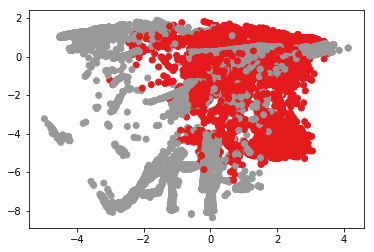

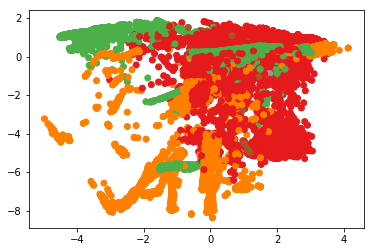

In [37]:
# Run PCA and plot the results
viz_train_data = np.array(
    pca_train_df.rdd.map(
        lambda row: [*row['pca_feats'], row['labels2_idx'], row['labels5_idx']]
    ).collect()
)
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,2], cmap="Set1")
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,3], cmap="Set1")
plt.show()

## 4. Train a random-forest and a logistic-regression models and evaluate them

### A. Using a random-forest on labels2 (attack / normal)

In [38]:
rf_t0 = time()
rf_labels2_classifier = RandomForestClassifier(
    labelCol='labels2_idx', featuresCol='idx_feats', predictionCol="labels2_pred_idx",
    seed=seed,
    numTrees=100,
    maxDepth=10,
    featureSubsetStrategy="sqrt")

# reuse labels2_converter to get back labels from idx
rf_labels2_pipeline = Pipeline(stages=[rf_labels2_classifier, labels2_converter])
rf_labels2_model = rf_labels2_pipeline.fit(final_train_df)
print("{0} secs".format(time() - rf_t0))

13.138820171356201 secs


In [39]:
# Make predictions over cross-validation dataset, and real test data
cv_labels2_predictions = rf_labels2_model.transform(final_cv_df)
test_labels2_predictions = rf_labels2_model.transform(final_test_df)

In [40]:
# Select (prediction, true label) and compute test error for cross-validation dataset
labels2_cv_accuracy = MulticlassClassificationEvaluator(
    labelCol="labels2_idx", predictionCol="labels2_pred_idx", metricName="accuracy"
).evaluate(cv_labels2_predictions)
print("Labels2 Cross-validation Error = %g" % (1.0 - labels2_cv_accuracy))

Labels2 Cross-validation Error = 0.00324765


In [41]:
# Select (prediction, true label) and compute test error for test dataset
labels2_test_accuracy = MulticlassClassificationEvaluator(
    labelCol="labels2_idx", predictionCol="labels2_pred_idx", metricName="accuracy"
).evaluate(test_labels2_predictions)
print("Labels2 Test Error = %g" % (1.0 - labels2_test_accuracy))

Labels2 Test Error = 0.238778


### B. Using logistic-regression on labels5 (DoS / Probe / R2L / U2R / normal)

In [42]:
lr_t0 = time()
lr_labels5_classifier = LogisticRegression(
    labelCol='labels5_idx', featuresCol='idx_feats', predictionCol="labels5_pred_idx", weightCol='weights',
    maxIter=100, standardization=False)

weights_dict = {
    'normal': 1.0,
    'DoS': 100.0,
    'Probe': 100.0,
    'R2L': 100.0,
    'U2R': 100.0
}

udf_weight = udf(lambda row: weights_dict[row], DoubleType())


RandomForestClassifier(
    labelCol='labels5_idx', featuresCol='idx_feats', predictionCol="labels5_pred_idx",
    seed=seed,
    numTrees=500,
    maxDepth=20,
    featureSubsetStrategy="sqrt")

# reuse labels5_converter to get back labels from idx
lr_labels5_pipeline = Pipeline(stages=[lr_labels5_classifier, labels5_converter])
lr_labels5_model = lr_labels5_pipeline.fit(final_train_df.withColumn('weights', udf_weight('labels5')))
print("{0} secs".format(time() - lr_t0))

5.376901388168335 secs


In [43]:
# Make predictions over cross-validation dataset, and real test data
cv_labels5_predictions = lr_labels5_model.transform(final_cv_df)
test_labels5_predictions = lr_labels5_model.transform(final_test_df)

In [44]:
# Select (prediction, true label) and compute test error for cross-validation dataset
labels5_cv_accuracy = MulticlassClassificationEvaluator(
    labelCol="labels5_idx", predictionCol="labels5_pred_idx", metricName="accuracy"
).evaluate(cv_labels5_predictions)
print("Labels5 Cross-validation Error = %g" % (1.0 - labels5_cv_accuracy))

Labels5 Cross-validation Error = 0.0753297


In [45]:
# Select (prediction, true label) and compute test error for test dataset
labels5_test_accuracy = MulticlassClassificationEvaluator(
    labelCol="labels5_idx", predictionCol="labels5_pred_idx", metricName="accuracy"
).evaluate(test_labels5_predictions)
print("Labels5 Test Error = %g" % (1.0 - labels5_test_accuracy))

Labels5 Test Error = 0.205997
